In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

%matplotlib inline

**Load Dataset**

(Data yang error saat loading di-skip)

In [6]:
df_software = pd.read_csv('amazon_reviews_us_Software_v1_00.tsv',
                      sep='\t',
                      error_bad_lines=False)

b'Skipping line 8021: expected 15 fields, saw 22\n'


Menampilkan head dataset

In [7]:
df_software.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42605767,R3EFW2STIYIY0I,B00MUTIDKI,248732228,McAfee 2015 Internet Security 3 PC (3-Users),Software,1,2,2,N,Y,I was very disappointed with this,I was very disappointed with this. The descrip...,2015-08-31
1,US,51771800,R12NR0R5A9F7FT,B00EPACNUG,531462352,Hallmark Card Studio 2014,Software,5,0,0,N,Y,Five Stars,"I had a little struggle getting familiarized, ...",2015-08-31
2,US,16053526,R1LSH74R9XAP59,B00164AZA4,473982505,Search and Rescue 4,Software,2,0,1,N,Y,Have windows 10?,Tried to download it on my Windows 10 and it w...,2015-08-31
3,US,15319481,R1QXUNTF76K7L6,B00E6LIEFM,189774198,Quickbooks Pro,Software,2,0,0,N,Y,"Disc was corrupt, had to spend a couple hours ...","Disc was corrupt, had to spend a couple hours ...",2015-08-31
4,US,1441820,R2F7DR75PS8NKT,B00VWEBG06,852470365,Windows 7 Professional with Service Pack 1 (64...,Software,5,0,0,N,Y,Five Stars,Just what I needed. Took a little longer to sh...,2015-08-31


**Dataset info**

In [8]:
df_software.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22529 entries, 0 to 22528
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        22529 non-null  object
 1   customer_id        22529 non-null  int64 
 2   review_id          22529 non-null  object
 3   product_id         22529 non-null  object
 4   product_parent     22529 non-null  int64 
 5   product_title      22529 non-null  object
 6   product_category   22529 non-null  object
 7   star_rating        22529 non-null  int64 
 8   helpful_votes      22529 non-null  int64 
 9   total_votes        22529 non-null  int64 
 10  vine               22529 non-null  object
 11  verified_purchase  22529 non-null  object
 12  review_headline    22528 non-null  object
 13  review_body        22529 non-null  object
 14  review_date        22528 non-null  object
dtypes: int64(5), object(10)
memory usage: 2.6+ MB


In [9]:
df_software.shape

(22529, 15)

Data set memiliki 14.784 baris dan 15 kolom.

Untuk Text Classification ini kolom yang digunakan hanya 
kolom 'review_body' dan 'star_rating'.

Tujuannya adalah untuk mengidentifikasi apakah text pada 'review_body' menunjukan POSITIVE atau NEGATIVE sentiment. Nantinya, model ini dapat digunakan untuk menganalisa hasil review produk di internet.




In [10]:
review = df_software[['review_body','star_rating']]

Kita definisikan angka star rating sebagai berikut:
- Star_rating 1-2 didefinisikan sebagai negative sentiment (0)
- Star_rating 3-5 didefinisikan sebagai positive sentiment (1)

Sehingga, nilai star rating lebih dari atau sama dengan 3 kita anggap sebagai positive sentiment (1).

In [11]:
pd.set_option('mode.chained_assignment', None)

review['star_rating'] = review['star_rating'].replace([1,2,3,4,5],[0,0,1,1,1])
review.rename(columns={'star_rating' : 'sentiment'}, inplace=True)

Pada kolom **review_body** terdapat kalimat yang terdiri dari beberapa kata dengan bermacam-macam tipe data. Saat tahap *Tokenizer* nanti, tipe data float atau integer tidak dapat diubah menjadi lowercase, sehingga akan memunculkan error. 
Oleh karena itu, semua data di kolom **review_body** diubah menjadi string agar saat proses *Tokenizer* tidak muncul error.

Mengubah data di kolom **review_body** menjadi tipe string:

In [12]:
review['review_body'] = review['review_body'].astype('str')

In [13]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22529 entries, 0 to 22528
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_body  22529 non-null  object
 1   sentiment    22529 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 352.1+ KB


Tipe data di kolom review_body sudah menjadi object.

Menampilkan data review sebelum proses preprocessing:

In [14]:
review.head(10)

,review_body,sentiment
0,I was very disappointed with this. The descrip...,0
1,"I had a little struggle getting familiarized, ...",1
2,Tried to download it on my Windows 10 and it w...,0
3,"Disc was corrupt, had to spend a couple hours ...",0
4,Just what I needed. Took a little longer to sh...,1
5,Didn't like having to get all of my old files ...,1
6,it does not work on windows 8. Do not buy.,0
7,I have tried for 3 days to get an answer from ...,0
8,love the game,1
9,Great software. Am now able to scan docs as PD...,1


#**PRE-PROCESSING**

**Menghilangkan html tags**

In [15]:
import re

def remove_html(text):
  clean = re.compile('<.*?>')
  return re.sub(clean, '', text)

def remove_URL(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

review['review_body'] = review['review_body'].apply(remove_html)
review['review_body'] = review['review_body'].apply(remove_URL)

**Mengubah semua suku kata menjadi lowercase**

In [16]:
def lower_text(text):
  return text.lower()

review['review_body'] = review['review_body'].apply(lower_text)

**Membuang special character**

In [17]:
def remove_special_char(text):
  x = ""

  for i in text:
    if i.isalnum():
      x = x+i
    else:
      x = x+ " "
  return x

review['review_body'] = review['review_body'].apply(remove_special_char)

**Membuang stop words, seperti is, are, am, dan lain-lain.**

In [18]:
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))


def remove_stopwords(text):
  text = [word.lower() for word in text.split() if word.lower() not in stop] 

  return " ".join(text)

review['review_body'] = review['review_body'].apply(remove_stopwords)

In [19]:
review.head()

,review_body,sentiment
0,disappointed description said compatible windo...,0
1,little struggle getting familiarized things cl...,1
2,tried download windows 10 even open guess new ...,0
3,disc corrupt spend couple hours getting downlo...,0
4,needed took little longer ship thought would,1


**Split dataset**

In [20]:
from sklearn.model_selection import train_test_split

x = review['review_body'].astype('str')
y = review['sentiment']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size = 0.2, random_state=26)

In [21]:
print(x_train.shape)
print(x_test.shape)

(18023,)
(4506,)


#Menggunakan tokenizer

Untuk memisahkan teks menjadi potongan-potongan berupa token, bisa berupa potongan huruf, kata, atau kalimat, sebelum dianalisis lebih lanjut. 

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index)+1 #---> +1 karena index dimulai dari 0

Untuk memeriksa index setiap kata:

In [23]:
word_index=tokenizer.word_index
word_index

{'windows': 1,
 '34': 2,
 'software': 3,
 'use': 4,
 'product': 5,
 'program': 6,
 'great': 7,
 'good': 8,
 'get': 9,
 'version': 10,
 'computer': 11,
 'like': 12,
 'would': 13,
 'time': 14,
 'one': 15,
 'work': 16,
 'new': 17,
 'used': 18,
 'easy': 19,
 'years': 20,
 'works': 21,
 '8': 22,
 'using': 23,
 '10': 24,
 '7': 25,
 'well': 26,
 'install': 27,
 '1': 28,
 'even': 29,
 'support': 30,
 'game': 31,
 'back': 32,
 'much': 33,
 'microsoft': 34,
 'need': 35,
 'year': 36,
 'could': 37,
 'also': 38,
 'buy': 39,
 'still': 40,
 'really': 41,
 'many': 42,
 'price': 43,
 'better': 44,
 'pc': 45,
 'upgrade': 46,
 'worked': 47,
 'love': 48,
 'way': 49,
 'system': 50,
 'old': 51,
 'problem': 52,
 'installed': 53,
 'find': 54,
 'first': 55,
 'make': 56,
 'free': 57,
 'tax': 58,
 'got': 59,
 'want': 60,
 'money': 61,
 'bought': 62,
 'user': 63,
 'problems': 64,
 'go': 65,
 'never': 66,
 'every': 67,
 'since': 68,
 'best': 69,
 'help': 70,
 'able': 71,
 'update': 72,
 'tried': 73,
 'without': 74

In [24]:
print('Total ada',vocab_size,'kosakata')

Total ada 19189 kosakata


Menggunakan pad sequences untuk menyamakan dimensi semua data ke maximum length yang ada.

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

Untuk memastikan word index nya sesuai, maka dicoba diperiksa data awal dan data setelah preprocessing.

sampling data ke 1234.

In [26]:
print(x_train.iloc[1234])  #---> data awal
print(X_train_seq[1234])   #---> setelah tokenizing

works expected
[21, 199]


Menggunakan reverse word index untuk mengecek (dengan cara arah berlawanan) apakah data awal dan data setelah preprocessing.

In [27]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [28]:
def decode(text):
  return " ".join([reverse_word_index.get(i, "?") for i in text])

In [29]:
print(decode(X_train_seq[1234])) #---> reverse
print(x_train.iloc[1234])        #---> data awal

works expected
works expected


Ada sedikit perbedaan dari data awal dan hasil preprocessing. Kemungkinan karena proses remove stopwords.

# **Recurrent Neural Network**

Pembuatan model RNN dengan Long Short-Term Memory (LSTM)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import layers

embedding_dim = 10

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          input_length=maxlen))
model.add(layers.LSTM(50,dropout=0.1,recurrent_dropout=0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss=['binary_crossentropy'],
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           191890    
                                                                 
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 204,141
Trainable params: 204,141
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train_pad, y_train,
                    epochs=5,
                    steps_per_epoch=50,
                    verbose=True,
                    validation_data=(X_test_pad,y_test),
                    batch_size=500)

Epoch 1/5
50/50 [==============================] - 29s 485ms/step - loss: 0.5582 - accuracy: 0.7606 - val_loss: 0.5039 - val_accuracy: 0.7810
Epoch 2/5
50/50 [==============================] - 33s 654ms/step - loss: 0.4557 - accuracy: 0.7935 - val_loss: 0.4380 - val_accuracy: 0.8409
Epoch 3/5
50/50 [==============================] - 30s 597ms/step - loss: 0.4049 - accuracy: 0.8105 - val_loss: 0.4107 - val_accuracy: 0.7783
Epoch 4/5
35/50 [====================>.........] - ETA: 9s - loss: 0.4743 - accuracy: 0.7634 

50/50 [==============================] - 23s 465ms/step - loss: 0.4743 - accuracy: 0.7634 - val_loss: 0.5186 - val_accuracy: 0.7765


In [37]:
print('Akurasi model = ', history.history['accuracy'][-1])

Akurasi model =  0.7634376883506775


In [38]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [39]:
losses = pd.DataFrame(history.history)

In [40]:
losses

,loss,accuracy,val_loss,val_accuracy
0,0.558164,0.760551,0.503940,0.780959
1,0.455726,0.793541,0.437964,0.840879
2,0.404931,0.810488,0.410696,0.778296
3,0.474275,0.763438,0.518557,0.776520


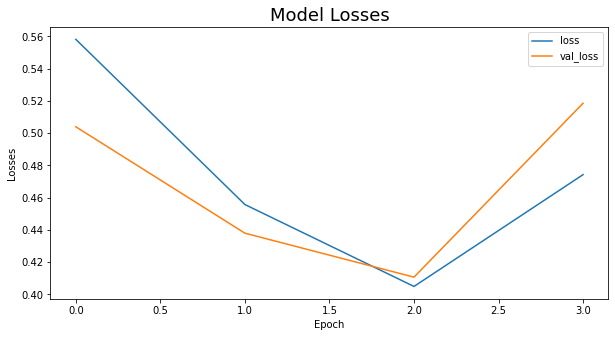

In [43]:
losses[['loss','val_loss']].plot(figsize=(10,5))
plt.title('Model Losses',fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.show()

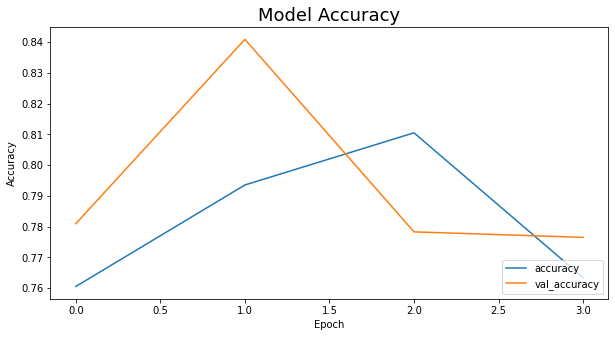

In [45]:
losses[['accuracy','val_accuracy']].plot(figsize=(10,5))
plt.title('Model Accuracy',fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()